# POC: Multimodal Prompt
Example of how to use LangChain with multimodal prompt.<br>
Adapted from <a target="_blank"  href="https://python.langchain.com/docs/how_to/multimodal_prompts/">https://python.langchain.com/docs/how_to/multimodal_prompts/</a><br>
<a target="_blank"  href="https://pillow.readthedocs.io/en/stable/index.html">Pillow reference</a><br>

Opened image OK:rack_00_good.jpg


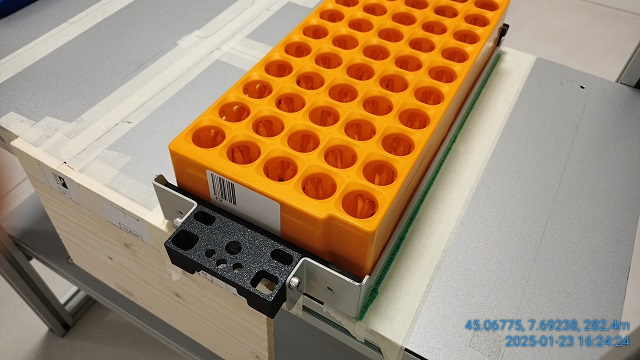

In [250]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from PIL import Image

import base64
import io
import IPython
import IPython.display as ipd
import logging as log
import os

GOOGLE_API_KEY_NAME='GOOGLE_API_KEY'
MODEL_NAME='gemini-1.5-flash'

IMAGE_OK_PATH=      'rack_00_good.jpg'
PROMPT_IMAGE_WIDTH= 480

if not GOOGLE_API_KEY_NAME in os.environ:
  log.error(f'Environment variable {GOOGLE_API_KEY_NAME} not set.')
assert GOOGLE_API_KEY_NAME in os.environ

assert os.path.exists(IMAGE_OK_PATH)

imageOK = Image.open( IMAGE_OK_PATH)
print(f'Opened image OK:{IMAGE_OK_PATH}')
ipd.display( imageOK)

In [251]:
def resizeImage( image, newWidth=512 ):
    (imgWidth, imgHeight)= image.size
    if (imgWidth<=0) or (imgHeight<=0):
        return image
    if imgWidth>newWidth:
        newHeight= (newWidth * imgHeight) // imgWidth
        return image.resize( size=( newWidth, newHeight))
    return image    

In [252]:
def base64Encode( image, format='JPEG'):
    imgBuffer= io.BytesIO()
    image.save(imgBuffer,format=format)
    return base64.b64encode( imgBuffer.getvalue()).decode('utf-8')

In [253]:
print(f'Image OK. Size:{imageOK.size}')

Image OK. Size:(640, 360)


Resized Image OK. Size:(480, 270)


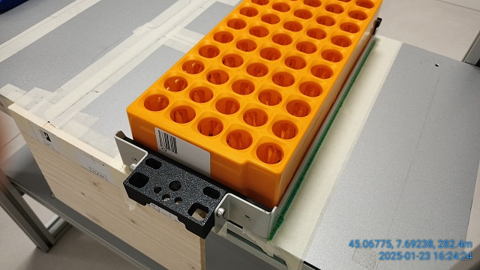

In [254]:
resizedImageOK= resizeImage( imageOK, PROMPT_IMAGE_WIDTH)
print(f'Resized Image OK. Size:{resizedImageOK.size}')
ipd.display( resizedImageOK)

### Base64 encode the image OK

In [255]:
"""
imgBuffer= io.BytesIO()
resizedImageOK.save(imgBuffer,format='JPEG')
encodedResizedImageOK= base64.b64encode( imgBuffer.getvalue()).decode('utf-8')
print(f'encodedResizedImageOK len:{ len(encodedResizedImageOK)}')
"""
encodedResizedImageOK= base64Encode( resizedImageOK)
print(f'encodedResizedImageOK len:{ len(encodedResizedImageOK)}')

encodedResizedImageOK len:28244


### Load, resize and base64 encode the checked image.

encodedCheckImage len:27164


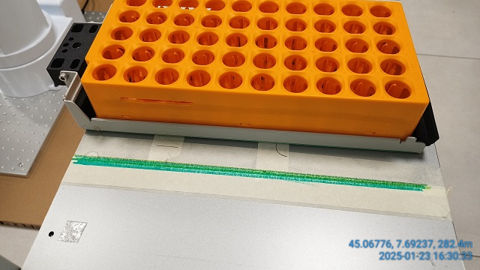

In [256]:
CHECK_IMAGE_PATH= 'rack_07_bad.jpg'
"""
rack_01_bad.jpg  rack_02_bad.jpg  rack_03_bad.jpg  rack_04_good.jpg  rack_05_good.jpg  rack_06_bad.jpg rack_07_bad.jpg
"""
assert os.path.exists(CHECK_IMAGE_PATH)
checkImage= resizeImage( Image.open( CHECK_IMAGE_PATH), PROMPT_IMAGE_WIDTH)
encodedCheckImage= base64Encode( checkImage)
print(f'encodedCheckImage len:{ len(encodedCheckImage)}')

ipd.display( checkImage)

### Classify the checked Image using the LLM

In [257]:
promptTemplate = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant that is able to classify images in the field of Laboratory automation"),
        ("user", """
You are shown an image of a rack placed on a shelf. The rack is a plastic object that can contain tubes. 
The rack is considered well positioned if:

. One short side of the rack is close to the edge inside the shelf or on the edge, the short side is parallel to the edge, but not outside of the shelf
. the long side of the rack is parallel and close to a green line on the shelf, touching the green line, but not crossing
. the rack must not cross or hide the green line on the shelf.

If the rack meets both conditions, respond with: YES.
If the rack does not meet any of these conditions, respond with: NO.
If you are unable to determine whether the rack meets these conditions, respond with UNSURE.

Please reply with a first line containing the word: YES, NO, or UNSURE, and nothing else.
In the next line, explain why you classified the image like that.

The next message shows an image to which you must reply with:
YES 
followed by the explanation.
        """),
        ("user",[ {"type": "image_url","image_url": {"url": "data:image/jpeg;base64,{image_ok_data}"},}]),
        ("user", "Now, classify the following image and reply with either: YES, NO, or UNSURE; followed by the explanation."),
        ("user",[ {"type": "image_url","image_url": {"url": "data:image/jpeg;base64,{image_check_data}"},}]),
    ]
)

In [258]:
"""
model = ChatGoogleGenerativeAI(model=MODEL_NAME, 
                               max_output_tokens=100,
                               temperature=0.0)
"""                               
model = ChatOpenAI(model="gpt-4o-mini")


parser= StrOutputParser()
chain = promptTemplate | model | parser

In [259]:
result = chain.invoke({'image_ok_data': encodedResizedImageOK,
                      'image_check_data':encodedCheckImage})

In [260]:
print(result)

YES  
The rack is properly positioned with one short side close to the edge of the shelf and parallel to it. The long side of the rack is also touching the green line without crossing it, meeting both conditions specified.


In [261]:
resultRows=result.split('\n')
len(resultRows)

2

In [263]:
( len(resultRows)>0 ) and ( resultRows[0].strip().upper().startswith('YES') )

True